# 🚶‍♂️ Pedestrian Traffic Prediction on Bahnhofstrasse (Zurich)

This project uses hourly foot traffic data from Zurich’s Bahnhofstrasse to explore pedestrian behavior and build a model to predict foot traffic patterns based on time, weather, and location.

📍 Dataset: [Opendata Zurich – Passantenfrequenzen](https://opendata.swiss/en/dataset/passantenfrequenzen-an-der-bahnhofstrasse-stundenwerte)  
🎯 Goal: Predict hourly pedestrian counts  
🔧 Tools: Python, Pandas, Seaborn, scikit-learn, XGBRegressor 
📈 Bonus: Add lag features and log-transformed targets for smarter prediction

## 📥 Load Dataset and Check Basic Info

We load the CSV file manually downloaded from opendata.swiss and perform basic inspection of the data structure.

In [1]:
import pandas as pd

# Load your CSV (adjust path if needed)
data = pd.read_csv("../data/foot_traffic.csv")

# Check structure
print(data.shape)
data.head()

(122560, 38)


,timestamp,location_id,location_name,ltr_label,rtl_label,weather_condition,temperature,pedestrians_count,unverified,collection_type,...,zone_3_pedestrians_count,zone_3_ltr_pedestrians_count,zone_3_rtl_pedestrians_count,zone_3_adult_pedestrians_count,zone_3_child_pedestrians_count,zone_99_pedestrians_count,zone_99_ltr_pedestrians_count,zone_99_rtl_pedestrians_count,zone_99_adult_pedestrians_count,zone_99_child_pedestrians_count
0,2021-09-28T22:00:00Z,329,Bahnhofstrasse (Mitte),Hauptbahnhof,Bürkliplatz,cloudy,13.51,151,False,measured,...,47.0,30.0,17.0,47.0,0.0,NaN,NaN,NaN,NaN,NaN
1,2021-09-28T22:00:00Z,331,Bahnhofstrasse (Nord),Bürkliplatz,Hauptbahnhof,cloudy,13.51,118,False,measured,...,40.0,10.0,30.0,40.0,0.0,NaN,NaN,NaN,NaN,NaN
2,2021-09-28T22:00:00Z,330,Bahnhofstrasse (Süd),Bürkliplatz,Hauptbahnhof,cloudy,13.51,203,False,measured,...,64.0,11.0,53.0,59.0,5.0,0.0,0.0,0.0,0.0,0.0
3,2021-09-28T22:00:00Z,670,Lintheschergasse,Hauptbahnhof,Uraniastraße,cloudy,13.51,0,False,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-09-28T23:00:00Z,329,Bahnhofstrasse (Mitte),Hauptbahnhof,Bürkliplatz,cloudy,13.46,19,False,measured,...,11.0,1.0,10.0,11.0,0.0,NaN,NaN,NaN,NaN,NaN


## 🧹 Clean the Data

We keep only entries from Bahnhofstrasse (excluding Lintheschergasse) and remove unused or incomplete columns such as `collection_type` and `zone_99`. We also remove rows with no recorded pedestrian activity.

In [2]:
# Keep only Bahnhofstrasse locations
bahnhof_data = data[data['location_name'].str.contains('Bahnhofstrasse')].copy()

# Drop zone_99 and collection_type
zone_99_cols = [col for col in bahnhof_data.columns if col.startswith('zone_99')]
bahnhof_data.drop(columns=['collection_type'] + zone_99_cols, inplace=True)

# Drop rows where all counts are 0 (invalid sensor readings)
bahnhof_data = bahnhof_data[bahnhof_data['pedestrians_count'] > 0]

# Reset index for safety
bahnhof_data.reset_index(drop=True, inplace=True)

# Check for null values
nulls = bahnhof_data.isnull().sum()
print(nulls[nulls > 0])

# Check result
print("Cleaned shape:", bahnhof_data.shape)
bahnhof_data.head()

Series([], dtype: int64)
Cleaned shape: (84973, 32)


,timestamp,location_id,location_name,ltr_label,rtl_label,weather_condition,temperature,pedestrians_count,unverified,ltr_pedestrians_count,...,zone_2_pedestrians_count,zone_2_ltr_pedestrians_count,zone_2_rtl_pedestrians_count,zone_2_adult_pedestrians_count,zone_2_child_pedestrians_count,zone_3_pedestrians_count,zone_3_ltr_pedestrians_count,zone_3_rtl_pedestrians_count,zone_3_adult_pedestrians_count,zone_3_child_pedestrians_count
0,2021-09-28T22:00:00Z,329,Bahnhofstrasse (Mitte),Hauptbahnhof,Bürkliplatz,cloudy,13.51,151,False,93,...,60.0,25.0,35.0,56.0,4.0,47.0,30.0,17.0,47.0,0.0
1,2021-09-28T22:00:00Z,331,Bahnhofstrasse (Nord),Bürkliplatz,Hauptbahnhof,cloudy,13.51,118,False,35,...,53.0,14.0,39.0,51.0,2.0,40.0,10.0,30.0,40.0,0.0
2,2021-09-28T22:00:00Z,330,Bahnhofstrasse (Süd),Bürkliplatz,Hauptbahnhof,cloudy,13.51,203,False,58,...,118.0,37.0,81.0,112.0,6.0,64.0,11.0,53.0,59.0,5.0
3,2021-09-28T23:00:00Z,329,Bahnhofstrasse (Mitte),Hauptbahnhof,Bürkliplatz,cloudy,13.46,19,False,8,...,2.0,1.0,1.0,1.0,1.0,11.0,1.0,10.0,11.0,0.0
4,2021-09-28T23:00:00Z,331,Bahnhofstrasse (Nord),Bürkliplatz,Hauptbahnhof,cloudy,13.46,7,False,2,...,2.0,1.0,1.0,2.0,0.0,4.0,0.0,4.0,4.0,0.0


## 📆 Time-Based Feature Engineering

We extract features such as hour of day, day of week, weekend flag, month, and year from the timestamp. These help the model learn time-dependent patterns in foot traffic.

In [3]:
# Convert timestamp to datetime
bahnhof_data['timestamp'] = pd.to_datetime(bahnhof_data['timestamp'])

# Extract time-based features
bahnhof_data['hour'] = bahnhof_data['timestamp'].dt.hour
bahnhof_data['weekday'] = bahnhof_data['timestamp'].dt.weekday  # 0 = Monday
bahnhof_data['is_weekend'] = bahnhof_data['weekday'].apply(lambda x: 1 if x >= 5 else 0)
bahnhof_data['month'] = bahnhof_data['timestamp'].dt.month
bahnhof_data['year'] = bahnhof_data['timestamp'].dt.year

# Preview
bahnhof_data[['timestamp', 'hour', 'weekday', 'is_weekend', 'month', 'year']].head()

,timestamp,hour,weekday,is_weekend,month,year
0,2021-09-28 22:00:00+00:00,22,1,0,9,2021
1,2021-09-28 22:00:00+00:00,22,1,0,9,2021
2,2021-09-28 22:00:00+00:00,22,1,0,9,2021
3,2021-09-28 23:00:00+00:00,23,1,0,9,2021
4,2021-09-28 23:00:00+00:00,23,1,0,9,2021


## 🔁 Add Lag Features and Encode Categorical Data

To give the model context from previous time points, we add lag features: previous hour’s count and same hour from the previous day.  
We also convert categorical columns like `weather_condition` and `location_name` into numerical format using one-hot encoding.

In [4]:
import numpy as np

# Sort by time
bahnhof_data = bahnhof_data.sort_values('timestamp')

# Add lag features
bahnhof_data['prev_hour_count'] = bahnhof_data['pedestrians_count'].shift(1)
bahnhof_data['prev_hour_count_2'] = bahnhof_data['pedestrians_count'].shift(2)
bahnhof_data['prev_day_same_hour'] = bahnhof_data['pedestrians_count'].shift(24)
bahnhof_data['prev_year_same_hour'] = bahnhof_data['pedestrians_count'].shift(8760)

# Add rolling features (using shift(1) to avoid data leakage)
bahnhof_data['rolling_3h'] = bahnhof_data['pedestrians_count'].shift(1).rolling(window=3).mean()
bahnhof_data['rolling_6h'] = bahnhof_data['pedestrians_count'].shift(1).rolling(window=6).mean()
bahnhof_data['rolling_24h'] = bahnhof_data['pedestrians_count'].shift(1).rolling(window=24).mean()

# Drop rows with any NaNs caused by shifts/rolling
bahnhof_data.dropna(subset=[
    'prev_hour_count',
    'prev_hour_count_2',
    'prev_day_same_hour',
    'prev_year_same_hour',
    'rolling_3h',
    'rolling_6h',
    'rolling_24h'
], inplace=True)

# Cyclical features
bahnhof_data['sin_hour'] = np.sin(2 * np.pi * bahnhof_data['hour'] / 24)
bahnhof_data['cos_hour'] = np.cos(2 * np.pi * bahnhof_data['hour'] / 24)
bahnhof_data['sin_month'] = np.sin(2 * np.pi * bahnhof_data['month'] / 12)
bahnhof_data['cos_month'] = np.cos(2 * np.pi * bahnhof_data['month'] / 12)

# One-hot encode categorical columns
data_model = pd.get_dummies(bahnhof_data, columns=['weather_condition', 'location_name'])

# OPTIONAL: Preview new feature columns
data_model[[
    'pedestrians_count',
    'prev_hour_count',
    'prev_hour_count_2',
    'prev_day_same_hour',
    'prev_year_same_hour',
    'rolling_3h',
    'rolling_6h',
    'rolling_24h'
]].head()

,pedestrians_count,prev_hour_count,prev_hour_count_2,prev_day_same_hour,prev_year_same_hour,rolling_3h,rolling_6h,rolling_24h
8762,653,599.0,941.0,2823.0,151.0,789.000000,866.500000,1828.875000
8761,995,653.0,599.0,2496.0,118.0,731.000000,805.666667,1738.458333
8760,933,995.0,653.0,1496.0,203.0,749.000000,778.833333,1675.916667
8763,676,933.0,995.0,2630.0,19.0,860.333333,824.666667,1652.458333
8764,669,676.0,933.0,1537.0,7.0,868.000000,799.500000,1571.041667


## 🤖 Model: Predict Pedestrian Count (with Log Target)

We use a XGBRegressor to predict foot traffic.  
The target variable is log-transformed to reduce the impact of extreme spikes.  
We also include lag features and encoded weather/location data.

In [5]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# ---------------------
# Define feature columns
# ---------------------
features = [
    "hour", "weekday", "is_weekend", "month", "temperature",
    "prev_hour_count", "prev_hour_count_2", "prev_day_same_hour", "prev_year_same_hour",
    "rolling_3h", "rolling_6h", "rolling_24h",
    "sin_hour", "cos_hour", "sin_month", "cos_month"
] + [col for col in data_model.columns if col.startswith("weather_condition_")] \
  + [col for col in data_model.columns if col.startswith("location_name_")]

# ---------------------
# Prepare inputs and target
# ---------------------
X = data_model[features]
y = np.log1p(data_model['pedestrians_count'])  # log(1 + x)

# ---------------------
# Train/test split
# ---------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# ---------------------
# Train model
# ---------------------
model = XGBRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# ---------------------
# Predict and inverse log
# ---------------------
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test)

# ---------------------
# Evaluate
# ---------------------
mae = mean_absolute_error(y_test_actual, y_pred)
print(f"✅ Mean Absolute Error: {mae:.2f}")

✅ Mean Absolute Error: 139.84


## 📉 Prediction Results: Actual vs Predicted

We group the predictions into bins based on actual pedestrian counts  
and plot the average predicted value per bin.  
The closer the line is to the 45° reference line, the better the model’s accuracy.

/var/folders/th/t6s31y8j0_x8kmgybmgm1nr00000gn/T/ipykernel_20781/3580830579.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  binned = results_df.groupby('bin').mean()


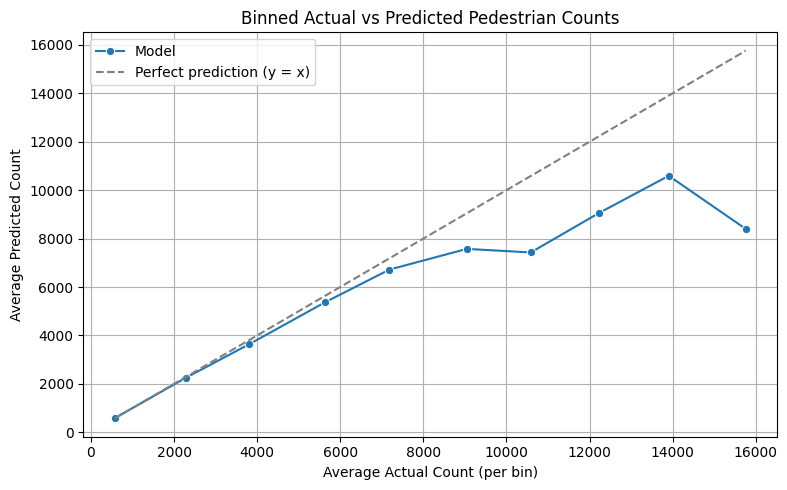

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Build DataFrame for comparison
results_df = pd.DataFrame({
    'actual': y_test_actual,
    'predicted': y_pred
})

# Bin actual values into equal-width ranges
results_df['bin'] = pd.cut(results_df['actual'], bins=10)
binned = results_df.groupby('bin').mean()

# Plot
plt.figure(figsize=(8, 5))
sns.lineplot(x=binned['actual'], y=binned['predicted'], marker='o', label='Model')
plt.plot(binned['actual'], binned['actual'], linestyle='--', color='gray', label='Perfect prediction (y = x)')
plt.title("Binned Actual vs Predicted Pedestrian Counts")
plt.xlabel("Average Actual Count (per bin)")
plt.ylabel("Average Predicted Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## 🧠 Final Results and Key Takeaways

✅ **Model**: XGBoost Regressor  
✅ **Features used**: time (hour, weekday, month), location, weather, multiple lagged traffic features (`prev_hour_count`, `prev_hour_count_2`, `prev_day_same_hour`, `prev_year_same_hour`, `rolling_3h`, `rolling_6h`, `rolling_24h`)  
✅ **Target**: pedestrian count (log-transformed to handle large spikes and skewed distribution)

📉 **MAE** (Mean Absolute Error): ~139  
📈 **Prediction accuracy**: significantly improved across the full range of pedestrian counts, including higher traffic levels  
🔥 Major improvement from the initial MAE of ~408 using a simple model without lag features or log-transform

---

👉 This project demonstrates how public open data can be transformed into actionable insights with classic and advanced ML techniques.  
Valuable for urban planning, footfall prediction, retail strategy, or smart city development.

In [8]:
import joblib

# Save model
joblib.dump(model, "../model/xgb_model.pkl")

# Save list of features
joblib.dump(features, "../model/features.pkl")

['../model/features.pkl']